In [93]:
# import necessary dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from scipy.linalg import expm
from functools import reduce
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from time import time
from tqdm import tqdm
from collections import deque
import networkx as nx
from qiskit.quantum_info import random_clifford

# FALQON Class

Note that $H_p = -\frac{1}{2} \sum_{(i,j) \in E} \left(I-Z_i Z_j \right)$, where $G = (V,E)$.

In [124]:
class FQA:
    
    def __init__(self, G, dt):
        '''
        G  : graph for which maxcut is being solved, as a networkx graph
        dt : timestep
        '''
        # construct Hamiltonians
        self.Hp = self.get_problem(G)
        self.Hd = self.get_driver()
        
        # construct variables of interest
        self.dt = dt
        self.sol = eigh(self.Hp)[1][:,0]
        self.state = expm(-1j*dt*self.Hp) @ eigh(self.Hd)[1][:,0]  # start in ground state of driver, evolved by problem
        self.params = deque()
        self.overlaps = deque()
        self.objvals = deque()
        self.gse = np.dot(np.conjugate(self.sol), self.Hp @ self.sol)
    
    
    def evolve(self, m):
        '''run the fqa for m layers'''
        for _ in tqdm(range(m)):
            self.one_layer()
    
    def rand_evolve(self, m):
        '''run the randomized fqa for m layers'''
        for _ in tqdm(range(m)):
            self.one_rand_layer()
    
    
    def one_layer(self):
        '''evolve one layer of fqa'''
        self.params.append(self.get_param(self.Hd))
        self.state = expm(-1j*self.dt*self.params[-1]*self.Hd) @ self.state
        self.state = expm(-1j*self.dt*self.Hp) @ self.state
        self.objvals.append(self.get_objval())
        self.overlaps.append(np.abs(np.dot(np.conjugate(self.sol), self.state))**2)
    
    def one_rand_layer(self):
        '''evolve one layer of the randomized fqa'''
        Vk = random_clifford(self.n).to_matrix()
        curr_H = Vk @ self.Hd @ np.conjugate(Vk).T
        self.params.append(self.get_param(curr_H))
        self.state = expm(-1j*self.dt*self.params[-1]*curr_H) @ self.state
        self.objvals.append(self.get_objval())
        self.overlaps.append(np.abs(np.dot(np.conjugate(self.sol), self.state))**2)
    
    
    def get_param(self, H):
        '''get parameter for Hamiltonian H with current state'''
        return -1j * np.dot(np.conjugate(self.state), (H @ self.Hp - self.Hp @ H) @ self.state)
    
    
    def get_objval(self):
        '''get value of objective function at current state'''
        return np.dot(np.conjugate(self.state), self.Hp @ self.state)
    
    
    def get_driver(self):
        '''construct driver Hamiltonian'''
        # initialize
        X = np.array([[0, 1],[1, 0]])
        Hd = np.kron(X, np.eye(2**(self.n-1)))

        # loop over qubits
        for j in range(1, self.n-1):
            Hd += reduce(np.kron, [np.eye(2**j), X, np.eye(2**(self.n-j-1))])

        # add final connection
        Hd += np.kron(np.eye(2**(self.n-1)), X)
        return Hd
    
    
    def get_problem(self, G):
        '''construct problem Hamiltonian'''
        self.n = G.number_of_nodes()
        
        # initialize the Hamiltonian and Pauli-Z matrices
        Hp = np.zeros((2**self.n, 2**self.n))
        Z = np.array([[1,0],[0,-1]])

        # add terms for each edge in the graph
        for i, j in G.edges():
            op = np.eye(1)
            for k in range(self.n):
                if k == i or k == j:
                    op = np.kron(op, Z)
                else:
                    op = np.kron(op, np.eye(2))
            Hp -= 1/2 * (np.eye(2**self.n) - op)
        return Hp

# Testing Class

## Four Qubits

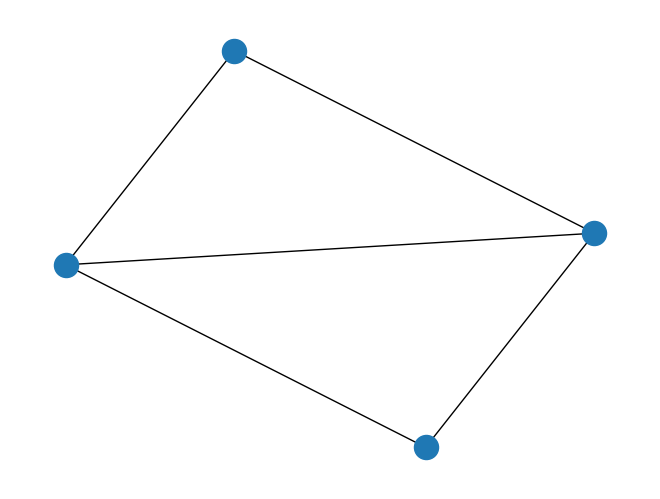

In [125]:
G = nx.erdos_renyi_graph(4, 0.78)
nx.draw(G)
FALQON4 = FQA(G, 0.05)

In [127]:
FALQON4.evolve(200)

100%|█████████████████████████████████| 200/200 [00:00<00:00, 2307.02it/s]


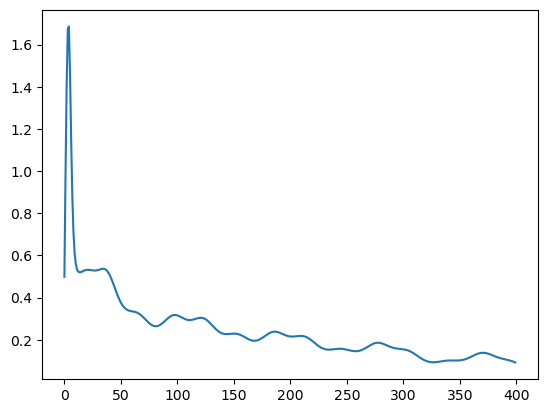

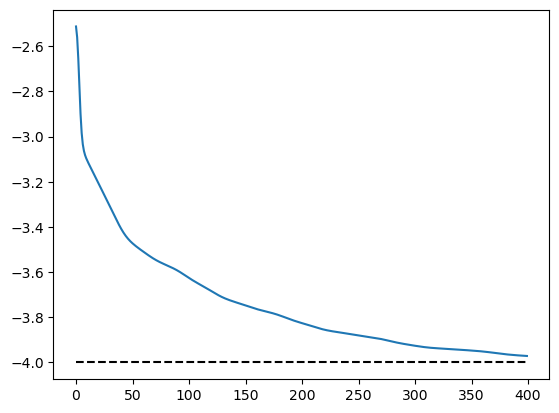

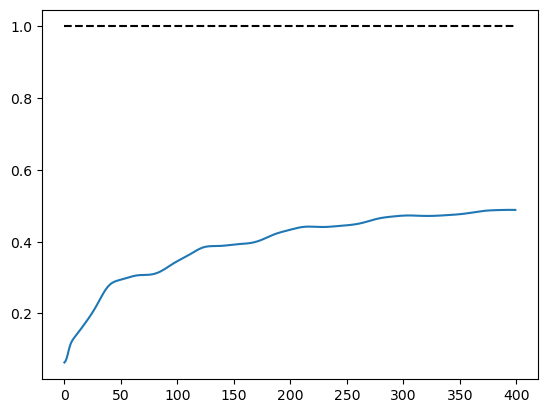

In [128]:
plt.plot(FALQON4.params)
plt.show()

plt.plot(FALQON4.objvals)
plt.plot(FALQON4.gse * np.ones(len(FALQON4.objvals)), "k--")
plt.show()

plt.plot(FALQON4.overlaps)
plt.plot(np.ones(len(FALQON4.overlaps)), "k--")
plt.show()

## Six Qubits

In [129]:
G = nx.random_regular_graph(3, 8)

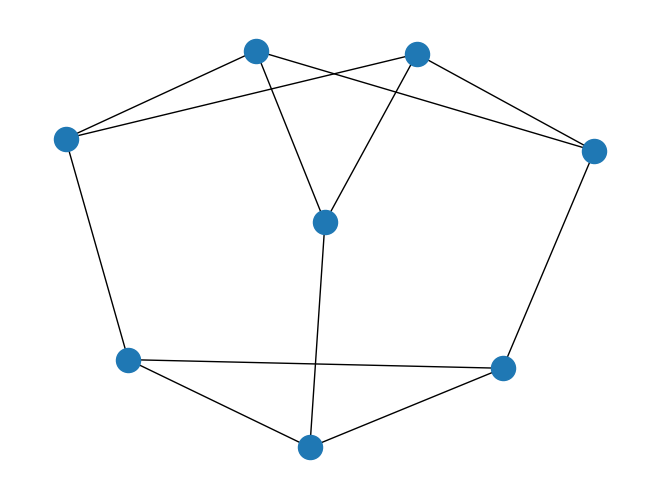

In [130]:
nx.draw(G)

In [133]:
FALQON1 = FQA(G, 0.05)

In [134]:
FALQON1.evolve(1000)

100%|█████████████████████████████████| 1000/1000 [00:31<00:00, 31.92it/s]


In [111]:
FALQON1.rand_evolve(1000)

100%|█████████████████████████████████| 1000/1000 [00:53<00:00, 18.64it/s]


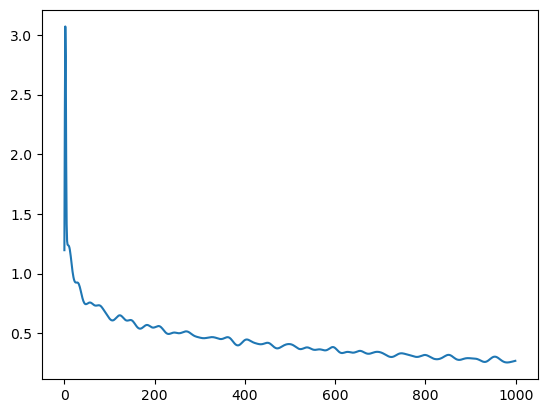

In [135]:
plt.plot(FALQON1.params)

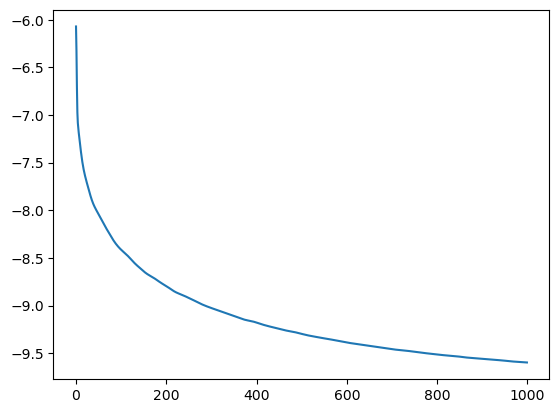

In [136]:
plt.plot(FALQON1.objvals)

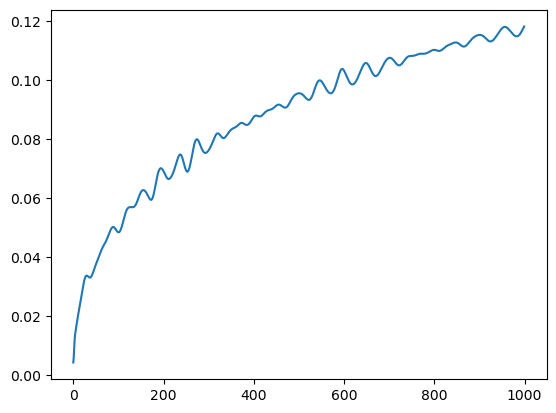

In [137]:
plt.plot(FALQON1.overlaps)